# IBM Attrition Study

Le but de cette étude est de prédire le taux d'attrition des employées d'IBM en fonction de plusieurs variables, qui concernent à la fois des données personnelles sur l'individu (son âge, son niveau d'étude, etc), des données professionelles (comme le département dans lequel l'individu travaille, son salaire, etc) et l'appréciation de l'individu sur son travail (qualité de ses relations avec ses collègues, work-life balance etc). Nous avons mis en place plusieurs algorithme de prédiction et comparé leurs performances. 

# 1- Analyse des données 
# 2- Sélection des variables 
    a- Suppression des variables corrélées 
    b- Comparaison des modèles Scikit learn et Statsmodels 
    c- Backwards selection avec plusieurs méthodes de sélection 
# 3- Comparaison des modèles prédictifs 
    a- Création d'un benchmark model : le dummy classifier 
    b- Regression avec Skilearn et Statsmodels 
    c- SVM 
    d- Comparaison des modèles par ROC Curve 

# Importation de la base de donnée et description de nos données

Téléchargement des données : Connectez vous sur une autre page de votre navigateur à votre compte Kaggle. 
Si vous n'avez pas de compte Kaggle, nous vous avons fourni en pièce jointe par mail la base de donnée

In [4]:
import urllib.request as ur
ur.urlretrieve ("https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv"
                , "WA_Fn-UseC_-HR-Employee-Attrition.zip")

('WA_Fn-UseC_-HR-Employee-Attrition.zip',
 <http.client.HTTPMessage at 0x112fc9ef0>)

In [5]:
# les libraries dont nous aurons besoin 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns #statistical data visualization
import statsmodels.api as sm # pour faire des modèles statistiques
import statsmodels.tools.tools as smt
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC
from scipy import stats

/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
%matplotlib inline 
#pour que nos graphes soient inclus dans notre notebook, en dessous de notre code 

In [7]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")

#Première analyse de notre data set
print('Notre indexation:', df.index)
print('Notre base de donnée est constituée de', df.shape[1], 'variables et de', df.shape[0], 'observations. \n')

Notre indexation: RangeIndex(start=0, stop=1470, step=1)
Notre base de donnée est constituée de 35 variables et de 1470 observations. 



In [8]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [9]:
print('Voyons nos variables ainsi que leur nombre de données manquantes:\n',df.isnull().sum()) # pas de Missing Values
print ("Il n'y a aucune données manquantes.")

Voyons nos variables ainsi que leur nombre de données manquantes:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
Yea

## Quelques explications sur certaines variables de notre base de données:

- EmployeeCount renvoie toujours le nombre '1', nous allons donc supprimer cette colonne
- EmployeeNumber correspond à un numéro unique associé à un employé
- JobRole correspond au titre d'une personne
- Percent salary hike: pourcentage d'augmentation de salaire entre 2015 et 2016. 
- Les variables Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction et StockOptionLevel  sont des variables qualitatives notées de 1 à 4 (ou à 5), 1 étant la pire note et 4 (ou 5) la meilleure. 
    - Pour Education: Education 1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'
    - Environment satisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - JobInvolvement: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - JobSatisfaction :  1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - PerformanceRating : 1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'
    - RelationshipSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - WorkLifeBalance 1 'Bad' 2 'Good' 3 'Better' 4 'Best'

In [10]:
print('Intéressons nous maintenant au type de chaque variable: \n', df.dtypes)

Intéressons nous maintenant au type de chaque variable: 
 Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int

## Transformation des variables dans un format approprié

In [11]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")
print(sys.getsizeof(df))
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",", dtype={
    'Age': np.int8, 
    'Attrition': str, 
    'BusinessTravel': str, 
    'DailyRate': np.int16, 
    'Department': str, 
    'DistanceFromHome': np.int8, 
    'Education': np.int8, 
    'EducationField': str, 
    'EmployeeCount': np.int8, 
    'EmployeeNumber': np.int16, 
    'EnvironmentSatisfaction':np.int8, 
    'Gender': str,
    'JobRole': str, 
    'MaritalStatus': str,
    'Over18': str, 
    'OverTime': str, 
    'HourlyRate' :np.int8,
    'JobInvolvement': np.int8,
    'JobLevel': np.int8,
    'JobSatisfaction': np.int8, 
    'MonthlyIncome': np.int16, 
    'MonthlyRate': np.int16,
    'NumCompaniesWorked': np.int8, 
    'PercentSalaryHike': np.int8,
    'PerformanceRating': np.int8,
    'RelationshipSatisfaction': np.int8,
    'StandardHours': np.int8,
    'StockOptionLevel': np.int8,
    'TotalWorkingYears': np.int8,
    'TrainingTimesLastYear': np.int8,
    'WorkLifeBalance': np.int8,
    'YearsAtCompany': np.int8,
    'YearsInCurrentRole': np.int8,
    'YearsSinceLastPromotion': np.int8,
    'YearsWithCurrManager': np.int8})
print(sys.getsizeof(df))

1183073
921413


## Preprocessing 


### EmployeeCount, EmployeeNumber, StandardHours & Over18

In [12]:
print('Valeur EmployeeCount: ', df['EmployeeCount'].unique(), '\n') # A supprimer : 1 partout
print('Valeur StandardHours: ', df['StandardHours'].unique(), '\n') # A supprimer : 80 pour tout le monde
print('Valeur EmployeeNumber :', df['EmployeeNumber'].describe(), '\n') # A supprimer : matricule de l'employé

print('Nombre de Over18 dont la valeur vaut "Yes"', df[df['Over18']== 'Y'].shape[0], '\n')
print('Nombre de Over18 dont la valeur vaut "No"', df[df['Over18']=='N'].shape[0]) # A supprimer : Yes pour tout le monde

Valeur EmployeeCount:  [1] 

Valeur StandardHours:  [80] 

Valeur EmployeeNumber : count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: EmployeeNumber, dtype: float64 

Nombre de Over18 dont la valeur vaut "Yes" 1470 

Nombre de Over18 dont la valeur vaut "No" 0


### Rendons certaines variables plus lisibles

In [13]:
# Changement de certains noms de valeurs dans la base

df['Department'].replace(to_replace ='Research & Development', value = 'R&D', inplace = True)
df['Department'].replace(to_replace ='Human Resources', value = 'HR', inplace = True)
df['BusinessTravel'].replace(to_replace ='Travel_Rarely', value = 'Rarely', inplace = True)
df['BusinessTravel'].replace(to_replace ='Travel_Frequently', value = 'Frequently', inplace = True)

# Etude de la population

Etudions notre base de donnée: 

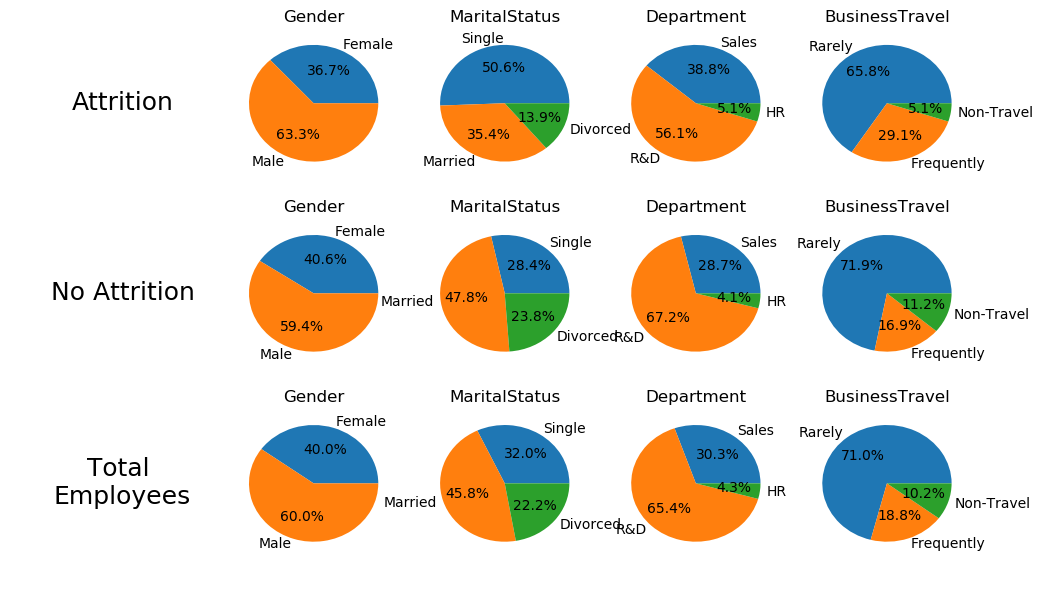

In [46]:
def titre(tlist,n):
    j = 0
    for i in n:
        plt.subplot(grid[i,0])
        plt.axis('off')
        plt.text(0.5,0.5, tlist[j] , ha='center', va='center', size = 18)
        j +=1
        
fig = plt.figure(figsize=(10,6), dpi=100)
grid = gridspec.GridSpec(3,5)
        
df0 = df[df['Attrition']=='Yes']
df1 = df[df['Attrition']=='No']
dA = [df0, df1, df]

titre(['Attrition', 'No Attrition', 'Total \nEmployees'],range(3))
var = ['Gender','MaritalStatus','Department','BusinessTravel']

j = 0
for d in dA:
    lab = list()
    k = 1
    for v in var:
        lab = df[v].unique()
        frac = list()
        for l in range(len(lab)):
            frac.append(d[d[v] == lab[l]].shape[0])
        plt.subplot(grid[j,k])
        plt.pie(frac, labels=lab, autopct='%1.1f%%')
        plt.title(v)
        k +=1
    j +=1

plt.tight_layout()
plt.show()  

_Analyse_

- Les hommes ont plus tendance à partir que les femmes
- Les personnes célibataires sont plus susceptibles de partir que les personnes mariées et divorcées. 
- Le département le plus concerné par les départs est le département des Sales, ensuite les RH
- Les personnes partant fréquemment en voyages d'affaire sont plus susceptibles de partir

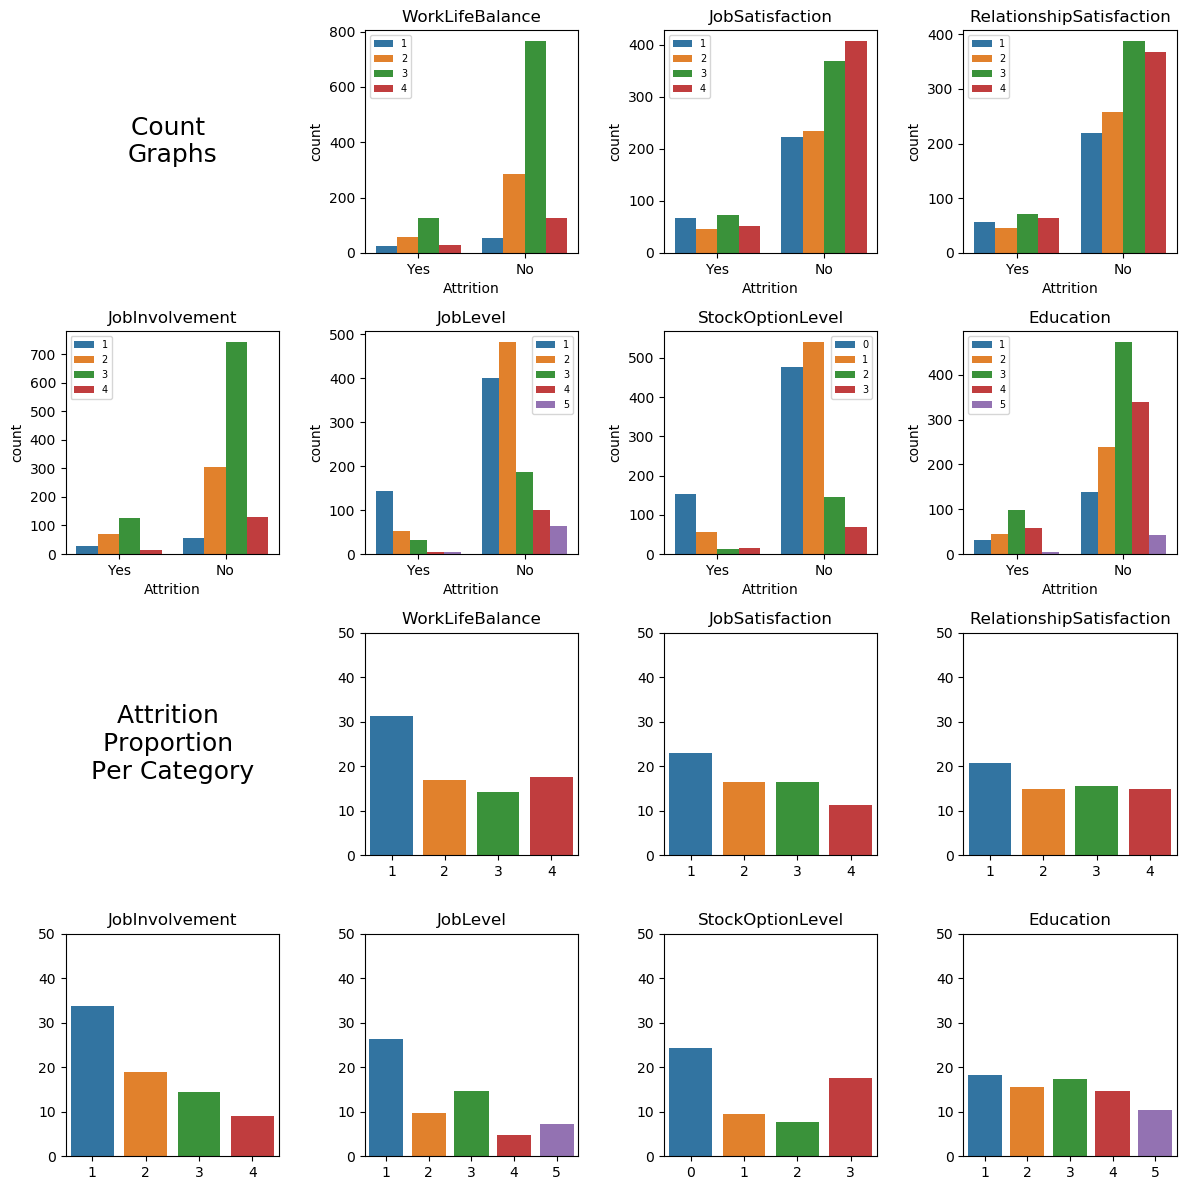

In [16]:
# Variables discrètes - diagrammes en bar

def prop_yes_category(c):
    result = pd.DataFrame()
    yes = df.groupby([c,'Attrition']).Attrition.count().reset_index(name ='Count').sort_values([c])
    tot = yes.groupby([c]).agg({'Count':np.sum}).reset_index().sort_values([c])
    yes = yes[yes['Attrition'] == 'Yes']
    result = [i/j*100 for i,j in zip(yes['Count'], tot['Count'])]
    return(result) 

def plot_prop(c):
    prop = prop_yes_category(c)
    n = sorted(df[c].unique())
    sns.barplot(x = n, y = prop)
    plt.title(c)
    plt.ylim([0,50])

fig = plt.figure(figsize=(12,12), dpi=100)
grid = gridspec.GridSpec(4,4)

titre(['Count \nGraphs','Attrition \nProportion \nPer Category'], [0,2])
col = ['WorkLifeBalance','JobSatisfaction', 'RelationshipSatisfaction','JobInvolvement', 'JobLevel', 'StockOptionLevel', 'Education']

i = 1
j = 0
for c in col:
    if i in range(1,4):
        plt.subplot(grid[0,i])
        sns.countplot(x= 'Attrition', hue = c, data= df)
        plt.title(c)
        plt.legend(prop={'size':7})
        
        plt.subplot(grid[2,i])
        plot_prop(c)
        i +=1
        
    else:
        plt.subplot(grid[1,j])
        sns.countplot(x= 'Attrition', hue = c, data= df)
        plt.title(c)
        plt.legend(prop={'size':7})
           
        plt.subplot(grid[3,j])
        plot_prop(c)
        j +=1

plt.tight_layout()
plt.show()

_Analyse_

- Comme pressenti, les personnes ayant répondu le plus négativement au questionnaire dans une catégorie partent proportionnellement plus que les autres (c'est surtout très clair pour les questions WorkLifeBalance et JobInvolvement)
- Les personnes ayant un niveau d'étude faible (Education) ont plus tendance à partir que les autres, mais la différence n'est vraiment pas significative. 
- Les personnes étant en bas de la hiérarchie en termes de postes de travail (JobLevel) ont également tendance à partir. 
- Une surprise, la tranche d'employés possédant le plus de StockOptions a le deuxième taux d'attrition le plus élevé, l'impact de StockOptionLevel sur l'attrition n'apparait pas clairement.

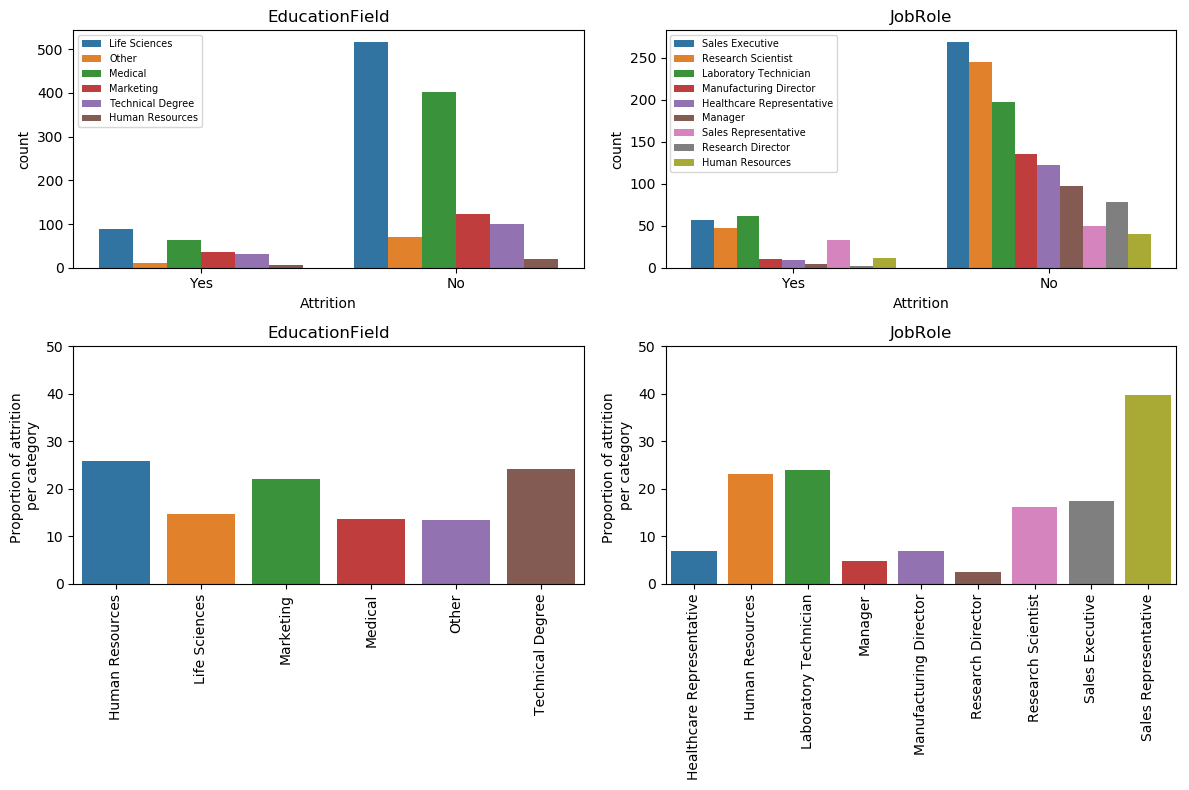

In [17]:
fig = plt.figure(figsize=(12,8), dpi=100)
grid = gridspec.GridSpec(2,2)

col = ['EducationField','JobRole']

i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.countplot(x= 'Attrition', hue = c, data= df)
    plt.title(c)
    plt.legend(prop={'size':7})
        
    plt.subplot(grid[1,i])
    plot_prop(c)
    plt.xticks(rotation=90)
    plt.ylabel('Proportion of attrition \nper category')
    i +=1
    
plt.tight_layout()
plt.show()

_Analyse_

- Le taux d'attrition n'est pas du tout le même en fonction du type de position dans l'entreprise. Les positions partant le plus sont les Sales Representatives (sûrement expliqué par la fréquence de voyages d'affaires)
- Les Managers et Directeurs sont ceux qui partent le moins.
- Les taux d'attrition diffèrent aussi en fonction du type d'études, mais c'est moins flagrant. Les personnes ayant étudié les Ressources Humaines sont paradoxalement ceux qui partent le plus, suivis par les ingénieurs/techniciens.

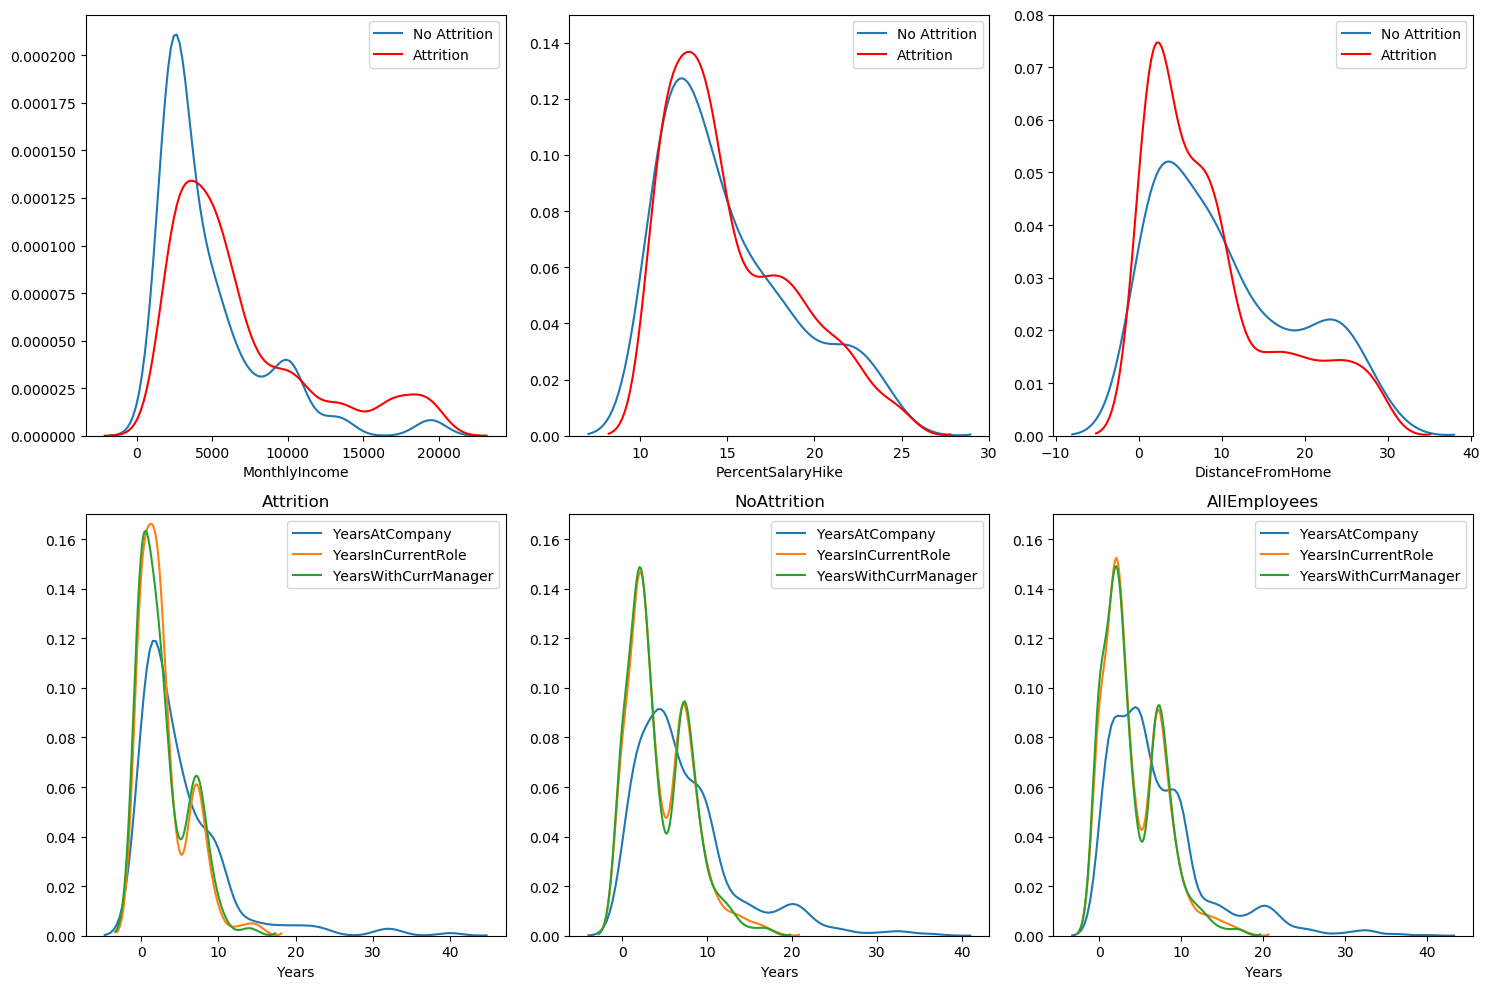

In [18]:
# Variables quantitatives

fig = plt.figure(figsize=(15,10), dpi=100)
grid = gridspec.GridSpec(2,3)

col = ['MonthlyIncome','PercentSalaryHike', 'DistanceFromHome']

i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.distplot(df0[c], hist = False, label = 'No Attrition')
    sns.distplot(df1[c], color = 'red', hist = False, label = 'Attrition')
    if i == 1:
        plt.ylim([0,0.15])
    elif i == 2:
        plt.ylim([0,0.08])
    i +=1

title = ['Attrition','NoAttrition','AllEmployees']
var = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']
j = 0
for d in dA:
    plt.subplot(grid[1,j])
    for v in var:
        sns.distplot(d[v], hist = False, label = v)
        plt.legend(prop={'size':10}, loc=1)
        plt.ylim([0,0.17])
        plt.xlabel('Years')
        plt.title(title[j])
    j +=1

plt.tight_layout()
plt.show()

##### _Analyse_

- Les personnes partant de l'entreprise ont en moyenne un salaire plus élevé que ceux ne partant pas
- de manière suprenante, l'augmentation de salaire a un faible impact sur l'attrition, la distribution de l'augmentation de salaire étant sensiblement la même dans les deux groupes
- L'Attrition est très forte pour un certain intervalle de distance, mais en dehors de cet intervalle, la distance n'influence plus beaucoup l'Attrition. Nous pouvons raisonnablement penser que cet intervalle de 0 à 15km correspond à une population urbaine, où il est aisé de changer de travail. 
- On peut voir que dans les trois groupes Attrition, No Attrition, et All Employees, la distribution de YearsInCurrentRole et Years withCurrentManager est sensiblement la même, on va pouvoir supprimer une des deux variables pour éviter une redondance d'informations
- Dans le groupe Attrition, la distribution des 3 variables YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager prends en moyenne des valeurs plus faibles que dans les deux autres groupes, les gens étant partis ont tendance à être dans l'entreprise depuis moins longtemps, et surtout a avoir moins changé de position (cf. plus faible différence entre courbe bleue et les autres dans le premier graphe)

# Préparation des données pour l'étude prédictive

Nous avons dû choisir un traitement pour nos variables catégoriques. Nous avons choisi de garder en variables continues les variables qui ont plus de quatre catégories et dont la moyenne fait sens (ex: les individus ont du noter leur JobSatisfaction sur une échelle allant de 1 à 4, 4 étant la meilleure note. Faire une moyenne sur cette variable fait bet et bien sens).

Il nous reste donc 7 variables catégoriques qu'il faut donc transformer en colonnes indicatrices de catégories. 
Les variables sont : 
- EducationField
- JobRole
- BusinessTravel
- Gender   
- OverTime
- MaritalStatus 
- Department 

### Traitement des variables catégoriques

In [19]:
var_cat = ['EducationField', 'JobRole', 'BusinessTravel','MaritalStatus', 'Department']
var_bin = ['Gender','OverTime','Attrition']
df1 = pd.DataFrame(index= range(df.shape[0]))
for var in var_cat:
    liste_cat='var'+'_'+var
    liste_cat = pd.get_dummies(df[var], prefix=var)
    df1= df1.merge(liste_cat, left_index= True, right_index=True )
    
for var in var_bin:
    liste_cat='var'+'_'+var
    liste_cat = pd.get_dummies(df[var], prefix=var, drop_first= True )
    df1= df1.merge(liste_cat, left_index= True, right_index=True )
    
df1.head()

,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,...,BusinessTravel_Rarely,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_HR,Department_R&D,Department_Sales,Gender_Male,OverTime_Yes,Attrition_Yes
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,1,0,1,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,1,0,0


In [20]:
dfc = df.merge(df1, left_index= True, right_index=True )
dfc = dfc.drop([var for var in var_cat], 1)
dfc = dfc.drop([var for var in var_bin], 1)
dfc = dfc.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18', 'EducationField_Other', 
                'JobRole_Research Director', 'BusinessTravel_Non-Travel', 'MaritalStatus_Divorced', 'Department_HR' ], 1) 
print ("Nous avons donc les variables suivantes: \n", dfc.columns)

# on a supprimé une catégorie par variable qualitative pour ne pas avoir de redondance - le but est d'avoir X de rang maximal

Nous avons donc les variables suivantes: 
 Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Technical Degree', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'BusinessTravel_Freque

# Modèle Selection

## Variables corrélées:

Nous allons étudier la corrélation des variables et supprimer les variables qui sont très corrélées afin de ne pas fausser notre modèle. 

Voici les coefficients de corrélation entre nos variables, au dessus d'un certain seuil - ici 0.65.


In [21]:
X = dfc.drop('Attrition_Yes', 1)
y = dfc['Attrition_Yes']

In [22]:
def correlation_table(X, limit):
    corr = pd.DataFrame(columns = ['Variable 1', 'Variable 2', 'Coefficient de Correlation'])
    i = 0
    n = len(X.columns)
    for j in range(n):
        for k in range(j+1,n):
            coef = np.corrcoef(X.iloc[:,j], X.iloc[:,k])[0,1]
            if abs(coef) > limit:
                corr.loc[i] = [X.columns[j], X.columns[k] ,coef]
                i +=1
    return(corr)

correlation_table(X, 0.65)

,Variable 1,Variable 2,Coefficient de Correlation
0,Age,TotalWorkingYears,0.680381
1,JobLevel,MonthlyIncome,0.950300
2,JobLevel,TotalWorkingYears,0.782208
3,MonthlyIncome,TotalWorkingYears,0.772893
4,PercentSalaryHike,PerformanceRating,0.773550
5,YearsAtCompany,YearsInCurrentRole,0.758754
6,YearsAtCompany,YearsWithCurrManager,0.769212
7,YearsInCurrentRole,YearsWithCurrManager,0.714365
8,JobRole_Sales Executive,Department_R&D,-0.733497
9,JobRole_Sales Executive,Department_Sales,0.808869


Afin de choisir pertinemment quelle variable garder regardons la corrélation avec la variable "Attrition". Ici H0 de notre test est: les moyennes de nos variables sont les mêmes pour une attrition égale à 1 ou 0. 

In [23]:
# 2-Sample t-test (mean comparison):

var = [['Age', 'TotalWorkingYears','JobLevel', 'MonthlyIncome'],['PercentSalaryHike', 'PerformanceRating'], ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager'] ]

def pval_ttest(var):
    pval = pd.DataFrame(columns = ['Var','pval_CorrelationWithAttrition'])
    i = 0
    for j in range(len(var)):
        for v in var[j]:
            a = dfc[dfc['Attrition_Yes']==1][v]
            b = dfc[dfc['Attrition_Yes']==0][v]
            if np.var(a) == np.var(b):
                p = stats.ttest_ind(a,b, equal_var = True)[1]
            else:
                p = stats.ttest_ind(a,b, equal_var = False)[1]
            pval.loc[i] = [v,p]
            i+=1
    return(pval)

pval_ttest(var)

,Var,pval_CorrelationWithAttrition
0,Age,1.379760e-08
1,TotalWorkingYears,1.159817e-11
2,JobLevel,9.844803e-13
3,MonthlyIncome,4.433589e-13
4,PercentSalaryHike,6.144301e-01
5,PerformanceRating,9.124808e-01
6,YearsAtCompany,2.285905e-07
7,YearsInCurrentRole,3.187390e-11
8,YearsWithCurrManager,1.185022e-10


Nous avons des groupements de variables qui sont très corrélées, comme le groupe 'Age', 'TotalWorkingyears', 'JobLevel' et 'Monthly Income'. 
JobLevel et MonthlyIncome sont très corrélé (plus de 0.95 de corrélation), alors nous allons supprimer JobLevel qui est une échelle de 1 à 5 au profit de MonthlyIncome qui est plus continu. De même TotalWorkingYears est très corrélé à MonthlyIncome (0.77) donc nous allons aussi le supprimer. Mais nous allons conserver la variable 'Age' parce qu'elle n'est pas tant corrélé au MonthlyIncome (0.5), on perderait de l'information. 

Dans le groupe 'PercentSalaryHike' vs. 'PerformanceRating': On supprime PerformanceRating une variable discrète au profit d'une variable plus continue.

Dans le grouepement : 'YearsAtCompany' vs. 'YearsInCurrentRole' vs. 'YearWithCurrManager': On supprime YearsAtCompany & YearsWithCurrManager, en raison de la p-value plus petite de 'YearsInCurrentRole'.

Dans le groupe 'JobRole' vs. 'Department' (2 catégories corrélées 2 à 2): On supprime Department car perte d'information lié au nombre de catégories.

In [24]:
dfc = dfc.drop(['TotalWorkingYears','JobLevel','PerformanceRating','YearsAtCompany','YearsWithCurrManager',
                'Department_R&D','Department_Sales'],1)
dfc = smt.add_constant(dfc, prepend = True)
dfc.columns

Index(['const', 'Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Technical Degree',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'BusinessTravel_Frequently', 'BusinessTravel_Rarely',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'Gender_Male',
       'OverTime_Yes', 'Attrition_

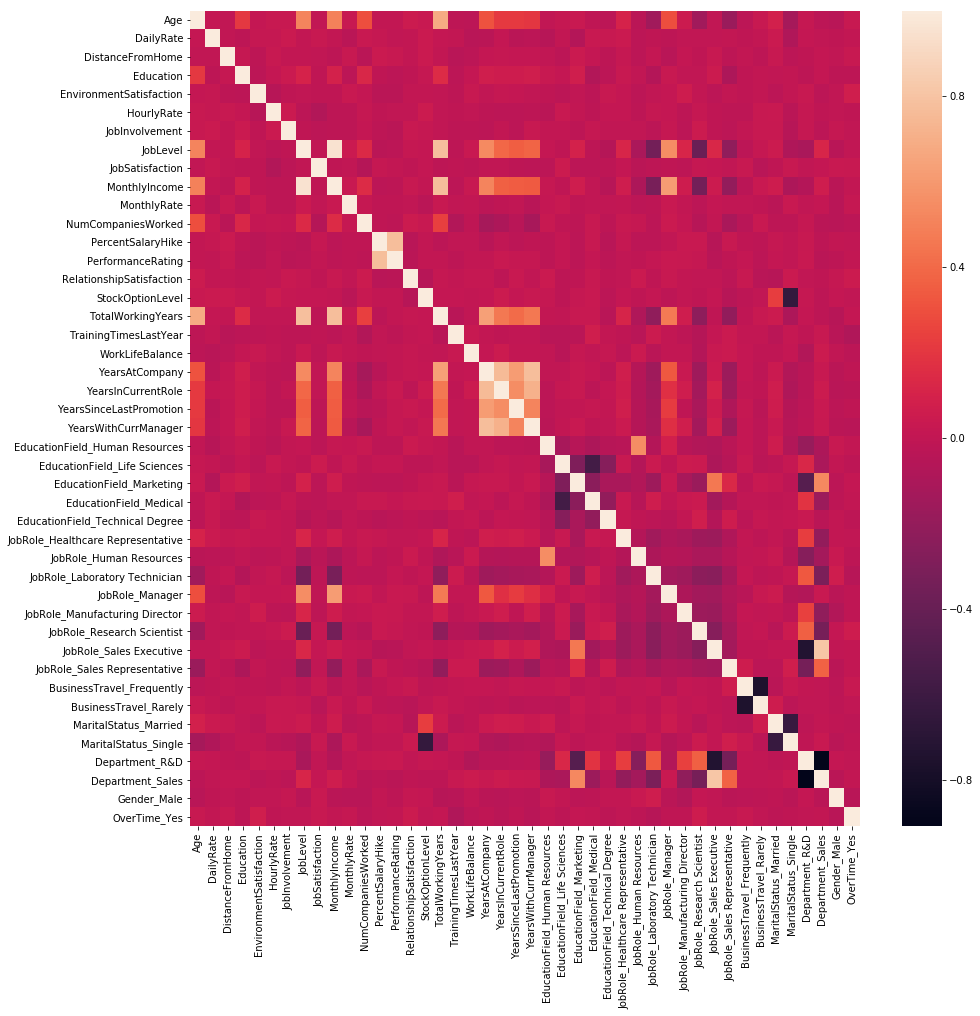

In [25]:
# Matrice de corrélation sur les variables X pour ne pas ajouter de 'poids' à une des features

fig2,ax2 = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), annot = False)

## Comparaison des deux modèles de Regression Logistique

- Fonction LogisticRegression du module sklearn
- Fonction Logit du module Statsmodels

In [26]:
X = dfc.drop('Attrition_Yes', 1)
y = dfc['Attrition_Yes']

In [27]:
# première regression logistique avec toutes nos variables - statsmodel: 
def smlogit_result(y,X):
    logit_model=sm.Logit(y,X)
    result=logit_model.fit(maxiter=500, disp=False)
    return(result)

result = smlogit_result(y,X)
result.summary()

/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1432
Method:                           MLE   Df Model:                           37
Date:                Wed, 17 Jan 2018   Pseudo R-squ.:                    -inf
Time:                        20:43:50   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                   -5.1895e+05
                                        LLR p-value:                     1.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.7167      1.526      0.470      0.639      -2.274       3.707
Age                                  -0.0441      0.012     -3.631      0.000      -0.068      -0.020
DailyRate                            -0.0003      0.000     -1.281      0.200      -0.001       0.000
DistanceFromHome                      0.0436      0.011      4.108      0.000       0.023       0.064
Education                             0.0025      0.087      0.029      0.977      -0.168       0.173
EnvironmentSatisfaction              -0.4106      0.081     -5.038      0.000      -0.570      -0.251
HourlyRate                            0.0014      0.004      0.332      0.740      -0.007       0.010
JobInvolvement                       -0.5514      0.120     -4.583      0.000      -0.787      -0.316
JobSatisfaction                      -0.3935      0.080     -4.914      0.000      -0.550      -0.237
MonthlyIncome                     -4.118e-05   5.18e-05     -0.795      0.427      -0.000    6.03e-05
MonthlyRate                        5.266e-06   1.23e-05      0.426      0.670   -1.89e-05    2.95e-05
NumCompaniesWorked                    0.1731      0.037      4.687      0.000       0.101       0.246
PercentSalaryHike                    -0.0141      0.024     -0.577      0.564      -0.062       0.034
RelationshipSatisfaction             -0.2426      0.081     -2.979      0.003      -0.402      -0.083
StockOptionLevel                     -0.2106      0.156     -1.349      0.177      -0.517       0.095
TrainingTimesLastYear                -0.1789      0.072     -2.470      0.014      -0.321      -0.037
WorkLifeBalance                      -0.3535      0.122     -2.888      0.004      -0.593      -0.114
YearsInCurrentRole                   -0.1631      0.036     -4.485      0.000      -0.234      -0.092
YearsSinceLastPromotion               0.1711      0.037      4.573      0.000       0.098       0.244
EducationField_Human Resources        0.7141      0.808      0.883      0.377      -0.870       2.299
EducationField_Life Sciences          0.1785      0.419      0.426      0.670      -0.643       1.000
EducationField_Marketing              0.5977      0.489      1.221      0.222      -0.362       1.557
EducationField_Medical                0.0782      0.426      0.184      0.854      -0.756       0.913
EducationField_Technical Degree       1.0417      0.470      2.216      0.027       0.121       1.963
JobRole_Healthcare Representative     0.8411      0.968      0.869      0.385      -1.057       2.739
JobRole_Human Resources               2.3089      1.100      2.098      0.036       0.152       4.466
JobRole_Laboratory Technician         2.3865      1.016      2.349      0.019       0.395       4.378
JobRole_Manager                       1.3114      0.942      1.393      0.164      -0.534       3.157
JobRole_Manufacturing Director        1.0303      0.969      1.063      0.288  

In [28]:
# Regression Logistique de Scikit learn:
# Sans intercept car const ajouté à dfc au départ

logreg = LogisticRegression(random_state = 0, fit_intercept = False ) #  seed utilisé par le random number generator
res_log = logreg.fit(X,y)

n = len(res_log.coef_[0])
var = pd.DataFrame(np.array(X.columns).reshape(n,1), columns = ['Variables'])
coef1 = pd.DataFrame(np.array(result.params), columns = ['Coef statsmodels'])
coef2 = pd.DataFrame(res_log.coef_[0].reshape(n,1), columns = ['Coef sklearn'])
coefs = pd.merge(coef1,coef2, right_index = True, left_index = True).reset_index(drop = True)
CoefLog = pd.merge(var,coefs, right_index = True, left_index = True)
CoefLog['Différence'] = CoefLog['Coef statsmodels'] - CoefLog['Coef sklearn']

CoefLog

# Les coefficients ne sont pas les mêmes, on va comparer les deux modèles grâce aux ROC curves plus bas

,Variables,Coef statsmodels,Coef sklearn,Différence
0,const,0.716722,0.102116,0.614607
1,Age,-0.044123,-0.011694,-0.032429
2,DailyRate,-0.000280,-0.000057,-0.000223
3,DistanceFromHome,0.043624,0.032203,0.011421
4,Education,0.002495,0.081090,-0.078594
5,EnvironmentSatisfaction,-0.410556,-0.225718,-0.184839
6,HourlyRate,0.001447,0.006017,-0.004570
7,JobInvolvement,-0.551417,-0.264035,-0.287381
8,JobSatisfaction,-0.393529,-0.201981,-0.191547
9,MonthlyIncome,-0.000041,-0.000106,0.000065


## Backwards regression avec Statsmodels 

Nous allons procéder à une backwards logistic regression, c'est à dire que nous allons mettre toutes les variables dans notre modèle, puis éliminer grâce aux p-values, les variables qui ne sont pas significatives pour la prédiction de l'attrition.

In [29]:
# Suppression de variables

pval_limit = 0.05
result = smlogit_result(y,X)
while  result.pvalues.max() > pval_limit:
    var_p_max = result.pvalues.argmax()
    if '_' in var_p_max: 
        var_cat = var_p_max.split('_')[0]
        var_cat_col = [i for i in list(X.columns.values) if var_cat in i]
        X = X.drop(var_cat_col, 1)
        print('Variable supprimée:' +'\033[1m' + var_cat + '\033[0m')
    else: 
        X = X.drop(var_p_max, 1)
        print('Variable supprimée: ' +'\033[1m' + var_p_max + '\033[0m')
    result = smlogit_result(y,X)
    
result.summary()

Variable supprimée: Education
Variable supprimée:EducationField
Variable supprimée: MonthlyRate
Variable supprimée: HourlyRate
Variable supprimée: MonthlyIncome
Variable supprimée: const
Variable supprimée: PercentSalaryHike
Variable supprimée:MaritalStatus
Variable supprimée: DailyRate


/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                           23
Date:                Wed, 17 Jan 2018   Pseudo R-squ.:                    -inf
Time:                        20:43:50   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                   -5.1895e+05
                                        LLR p-value:                     1.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0460      0.011     -4.322      0.000      -0.067      -0.025
DistanceFromHome                      0.0425      0.010      4.106      0.000       0.022       0.063
EnvironmentSatisfaction              -0.3749      0.078     -4.794      0.000      -0.528      -0.222
JobInvolvement                       -0.5412      0.115     -4.708      0.000      -0.766      -0.316
JobSatisfaction                      -0.3722      0.076     -4.871      0.000      -0.522      -0.222
NumCompaniesWorked                    0.1655      0.036      4.638      0.000       0.096       0.235
RelationshipSatisfaction             -0.2290      0.079     -2.901      0.004      -0.384      -0.074
StockOptionLevel                     -0.5923      0.114     -5.179      0.000      -0.816      -0.368
TrainingTimesLastYear                -0.1551      0.070     -2.227      0.026      -0.292      -0.019
WorkLifeBalance                      -0.2698      0.114     -2.363      0.018      -0.494      -0.046
YearsInCurrentRole                   -0.1636      0.035     -4.618      0.000      -0.233      -0.094
YearsSinceLastPromotion               0.1617      0.036      4.439      0.000       0.090       0.233
JobRole_Healthcare Representative     1.6395      0.696      2.357      0.018       0.276       3.003
JobRole_Human Resources               3.3050      0.704      4.695      0.000       1.925       4.685
JobRole_Laboratory Technician         3.3636      0.609      5.527      0.000       2.171       4.556
JobRole_Manager                       1.8200      0.787      2.312      0.021       0.277       3.363
JobRole_Manufacturing Director        1.9178      0.693      2.767      0.006       0.559       3.276
JobRole_Research Scientist            2.5327      0.601      4.211      0.000       1.354       3.711
JobRole_Sales Executive               2.9774      0.611      4.872      0.000       1.780       4.175
JobRole_Sales Representative          4.1276      0.652      6.328      0.000       2.849       5.406
BusinessTravel_Frequently             1.8872      0.390      4.842      0.000       1.123       2.651
BusinessTravel_Rarely                 1.0418      0.358      2.909      0.004       0.340       1.744
Gender_Male                           0.3824      0.177      2.156      0.031       0.035       0.730
OverTime_Yes                          1.8776      0.185     10.123      0.000       1.514       2.241
=====================================================================================================
"""

## Backwards regression Statsmodel, pvalues calculées à la main 

Essayons de faire cette sélection de variable à la main

In [30]:
# création d'un nouveau data frame 
X1 = dfc.drop('Attrition_Yes', 1)
X1.head()

,const,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel_Frequently,BusinessTravel_Rarely,MaritalStatus_Married,MaritalStatus_Single,Gender_Male,OverTime_Yes
0,1.0,41,1102,1,2,2,94,3,4,5993,...,0,0,1,0,0,1,0,1,0,1
1,1.0,49,279,8,1,3,61,2,2,5130,...,0,1,0,0,1,0,1,0,1,0
2,1.0,37,1373,2,2,4,92,2,3,2090,...,0,0,0,0,0,1,0,1,1,1
3,1.0,33,1392,3,4,4,56,3,3,2909,...,0,1,0,0,1,0,1,0,0,1
4,1.0,27,591,2,1,1,40,3,2,3468,...,0,0,0,0,0,1,1,0,1,0


In [31]:
def result_log0(X, y): 
    result = smlogit_result(y,X)
    params = result.params.values
    n = len(params)
    #params = params.reshape(n,)
    predic = result.predict(X)
    # On crée une matrice remplie de 0 et on remplie la diagonale avec la variance
    V = np.matrix(np.zeros(shape = (X.shape[0], X.shape[0])))
    np.fill_diagonal(V, np.multiply(predic, 1-predic)) # on calcule la variance d'une loi de Bernouilli
    # Covariance matrix
    covLogit = np.linalg.inv(np.dot(np.dot(X.T, V), X))
    # Standard errors
    sd= np.sqrt(np.diag(covLogit))
    #Wald statistics: 
    ws = params / sd
    #pvalue 
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in ws]
    # on crée un data frame pour avoir un output
    dfp = pd.DataFrame(index=X.columns)
    dfp["Coefficients"],dfp["Standard Errors"],dfp["Test de Wald"],dfp["P-value"] = [params,sd,ws,p_values]
    return (dfp)

In [32]:
# initialisation
dfp = result_log0(X1,y)
dfp

/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


,Coefficients,Standard Errors,Test de Wald,P-value
const,0.716722,1.525653,0.469781,6.385815e-01
Age,-0.044123,0.012152,-3.630849,2.921917e-04
DailyRate,-0.000280,0.000219,-1.281044,2.003804e-01
DistanceFromHome,0.043624,0.010620,4.107565,4.218995e-05
Education,0.002495,0.087186,0.028621,9.771708e-01
EnvironmentSatisfaction,-0.410556,0.081499,-5.037560,5.299124e-07
HourlyRate,0.001447,0.004358,0.332082,7.398747e-01
JobInvolvement,-0.551417,0.120306,-4.583436,4.961753e-06
JobSatisfaction,-0.393529,0.080078,-4.914302,9.908309e-07
MonthlyIncome,-0.000041,0.000052,-0.795093,4.266878e-01


In [33]:
# Suppression de variables

dfp = result_log0(X1,y)
pval_limit = 0.07

while  dfp['P-value'].max() > pval_limit:
    var_p_max2 = dfp['P-value'].argmax()
    if '_' in var_p_max2: 
        var_cat = var_p_max2.split('_')[0]
        var_cat_col = [i for i in list(X1.columns.values) if var_cat in i]
        X1 = X1.drop(var_cat_col, 1)
        print('Variable supprimée:' +'\033[1m' + var_cat + '\033[0m')
        dfp = result_log0(X1,y)
    else: 
        X1 = X1.drop(var_p_max2, 1)
        print('Variable supprimée: ' +'\033[1m' + var_p_max2 + '\033[0m')
        dfp = result_log0(X1,y)
        
dfp

/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Variable supprimée: Education
Variable supprimée:EducationField
Variable supprimée: MonthlyRate
Variable supprimée: HourlyRate
Variable supprimée: MonthlyIncome
Variable supprimée: const
Variable supprimée: PercentSalaryHike
Variable supprimée:MaritalStatus
Variable supprimée: DailyRate


,Coefficients,Standard Errors,Test de Wald,P-value
Age,-0.046003,0.010643,-4.322422,1.647074e-05
DistanceFromHome,0.042468,0.010344,4.105604,4.254552e-05
EnvironmentSatisfaction,-0.374908,0.078204,-4.793968,1.800976e-06
JobInvolvement,-0.541179,0.114953,-4.707838,2.739711e-06
JobSatisfaction,-0.372225,0.076413,-4.871244,1.228910e-06
NumCompaniesWorked,0.165467,0.035678,4.637733,3.835467e-06
RelationshipSatisfaction,-0.229018,0.078941,-2.901128,3.773593e-03
StockOptionLevel,-0.592290,0.114371,-5.178693,2.544291e-07
TrainingTimesLastYear,-0.155087,0.069646,-2.226789,2.611246e-02
WorkLifeBalance,-0.269823,0.114173,-2.363287,1.824324e-02


## Backwards suppression statsmodel & p-values calculées à la main

In [34]:
def result_log(X, y): 
    resLogit =logreg.fit(X,y)
    params = np.array(resLogit.coef_)
    n = len(resLogit.coef_[0])
    params = params.reshape(n,)
    predProbs = np.matrix(resLogit.predict_proba(X)) # 1ère colonne prédit la probabilité d'avoir 0, 2ème d'avoir 1
    # On crée une matrice remplie de 0 et on remplie la diagonale avec la variance
    V = np.matrix(np.zeros(shape = (X.shape[0], X.shape[0])))
    np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]).A1) # on calcule la variance d'une loi de Bernouilli
    # Covariance matrix
    covLogit = np.linalg.inv(np.dot(np.dot(X.T, V), X))
    # Standard errors
    sd= np.sqrt(np.diag(covLogit))
    #Wald statistics: 
    ws = params / sd ## supprimer le carré
    #pvalue 
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in ws]
    p_values = [round(x,4) for x in p_values]
    # on crée un data frame pour avoir un output
    dfp = pd.DataFrame(index=X.columns)
    dfp["Coefficients"],dfp["Standard Errors"],dfp["Test de Wald"],dfp["P-value"] = [params,sd,ws,p_values]
    return (dfp)

In [35]:
X2 = dfc.drop('Attrition_Yes', 1)
X2.head()

dfp = result_log(X2,y)
pval_limit = 0.07

while  dfp['P-value'].max() > pval_limit:
    var_p_max2 = dfp['P-value'].argmax()
    if '_' in var_p_max2: 
        var_cat = var_p_max2.split('_')[0]
        var_cat_col = [i for i in list(X2.columns.values) if var_cat in i]
        X2 = X2.drop(var_cat_col, 1)
        print('Variable supprimée:' +'\033[1m' + var_cat + '\033[0m')
        dfp = result_log(X2,y)
    else: 
        X2 = X2.drop(var_p_max2, 1)
        print('Variable supprimée: ' +'\033[1m' + var_p_max2 + '\033[0m')
        dfp = result_log(X2,y)
        
dfp

Variable supprimée:JobRole
Variable supprimée: WorkLifeBalance
Variable supprimée:BusinessTravel
Variable supprimée:EducationField
Variable supprimée: const
Variable supprimée:MaritalStatus
Variable supprimée:Gender
Variable supprimée: DailyRate
Variable supprimée: Education
Variable supprimée: RelationshipSatisfaction
Variable supprimée:OverTime
Variable supprimée: TrainingTimesLastYear
Variable supprimée: HourlyRate
Variable supprimée: PercentSalaryHike
Variable supprimée: JobInvolvement
Variable supprimée: MonthlyRate


,Coefficients,Standard Errors,Test de Wald,P-value
Age,-0.014655,0.007463,-1.963640,0.0498
DistanceFromHome,0.037746,0.008708,4.334596,0.0000
EnvironmentSatisfaction,-0.146214,0.060937,-2.399423,0.0165
JobSatisfaction,-0.131286,0.060955,-2.153825,0.0314
MonthlyIncome,-0.000099,0.000024,-4.039892,0.0001
NumCompaniesWorked,0.106901,0.030524,3.502242,0.0005
StockOptionLevel,-0.418109,0.098397,-4.249209,0.0000
YearsInCurrentRole,-0.132109,0.030571,-4.321393,0.0000
YearsSinceLastPromotion,0.115093,0.031318,3.674974,0.0002


# Modèles Prédictifs

## Séparation en training set/ test set

In [36]:
# Modèle backward regression avec la fonction statsmodel logit

dff = X.join(y)
train, test = train_test_split(dff, train_size=0.8, test_size = 0.2, random_state = 0)
X_train = train.drop('Attrition_Yes', 1)
y_train = train['Attrition_Yes']
X_test = test.drop('Attrition_Yes', 1)
y_test = test['Attrition_Yes']

print(X_train.shape)
print(X_test.shape)

(1176, 24)
(294, 24)


In [37]:
# Backward Regression Sklearn & pvalues à la main

dff1 = X1.join(y)
train1, test1 = train_test_split(dff1, train_size=0.8, test_size = 0.2, random_state = 0)
X1_train = train1.drop('Attrition_Yes', 1)
y1_train = train1['Attrition_Yes']
X1_test = test1.drop('Attrition_Yes', 1)
y1_test = test1['Attrition_Yes']

#print(X1_train.shape)
#print(X1_test.shape)

#X1_train.head()

In [38]:
# Backward Regression StatsModel & pvalues à la main

dff2 = X2.join(y)
train2, test2 = train_test_split(dff1, train_size=0.8, test_size = 0.2, random_state = 0)
X2_train = train2.drop('Attrition_Yes', 1)
y2_train = train2['Attrition_Yes']
X2_test = test2.drop('Attrition_Yes', 1)
y2_test = test2['Attrition_Yes']

In [39]:
# Pas de modele selection

train3, test3 = train_test_split(dfc, train_size=0.8, test_size = 0.2, random_state = 0)
X3_train = train3.drop('Attrition_Yes', 1)
y3_train = train3['Attrition_Yes']
X3_test = test3.drop('Attrition_Yes', 1)
y3_test = test3['Attrition_Yes']

print(X2_train.shape)
print(X2_test.shape)


(1176, 24)
(294, 24)


In [40]:
X_train_tot =[X_train,X1_train, X2_train, X3_train]
y_train_tot = [y_train,y1_train,y2_train, y3_train]
X_test_tot = [X_test,X1_test,X2_test, X3_test]
y_test_tot = [y_test,y1_test,y2_test, y3_test]

titre = ['Selection Statsmodel', 'Selection Statsmodel & by hand', 'Selection Sklearn & by hand','No Selection']
n = len(titre)

## Dummy Classifier

Ce dummy classifier va nous servir de base pour les scores des prochains classifiers.

In [41]:
def dummy_classifier(y_train,y_test):
    n = len(y_test.index)
    prop = sum(y_train)/len(y_train.index) # proportion de 1 dans y_train
    if prop < 0.5:
        result = np.zeros((n,1))
    else:
        result = np.ones((n,1))
    return(result)

def accuracy(conf_matrix):
    tot = sum(sum(conf_matrix))
    acc = (conf_matrix[0,0]+conf_matrix[1,1])/tot
    return(acc)

for i in range(n):
    print(titre[i])
    y_dum_pred = dummy_classifier(y_train_tot[i], y_test_tot[i])
    conf_matrix = confusion_matrix(y_test_tot[i], y_dum_pred) # horizontal : predicted, vertical : True values 
    print(conf_matrix)
    print('Accuracy', accuracy(conf_matrix))

Selection Statsmodel
[[245   0]
 [ 49   0]]
Accuracy 0.833333333333
Selection Statsmodel & by hand
[[245   0]
 [ 49   0]]
Accuracy 0.833333333333
Selection Sklearn & by hand
[[245   0]
 [ 49   0]]
Accuracy 0.833333333333
No Selection
[[245   0]
 [ 49   0]]
Accuracy 0.833333333333


## Regressions Logistiques

Nous allons utiliser les deux modèles de sklearn et statsmodels

In [42]:
# SKLEARN régression sur la base X_train, y_train

for i in range(n):
    print(titre[i])
    res_log = logreg.fit(X_train_tot[i], y_train_tot[i])

    # Prediction sur le training set
    y_predlog = res_log.predict(X_test_tot[i])
    conf_matrix = confusion_matrix(y_test_tot[i], y_predlog)
    y_score = res_log.score(X_test_tot[i],y_test_tot[i])
    print(conf_matrix)
    print('Accuracy', y_score)

Selection Statsmodel
[[241   4]
 [ 31  18]]
Accuracy 0.880952380952
Selection Statsmodel & by hand
[[241   4]
 [ 31  18]]
Accuracy 0.880952380952
Selection Sklearn & by hand
[[241   4]
 [ 31  18]]
Accuracy 0.880952380952
No Selection
[[239   6]
 [ 29  20]]
Accuracy 0.880952380952


In [43]:
# STATSMODELS regression

for i in range(n):
    print(titre[i])
    res_sm = smlogit_result(y_train_tot[i] ,X_train_tot[i] )

    # prediction sur le training set
    y_predsm = res_sm.predict(X_test_tot[i] )
    y_predsm = y_predsm.round()
    conf_matrix = confusion_matrix(y_test_tot[i] , y_predsm)
    print(conf_matrix)
    print('Accuracy', accuracy(conf_matrix))

Selection Statsmodel
[[240   5]
 [ 28  21]]
Accuracy 0.887755102041
Selection Statsmodel & by hand
[[240   5]
 [ 28  21]]
Accuracy 0.887755102041
Selection Sklearn & by hand
[[240   5]
 [ 28  21]]
Accuracy 0.887755102041
No Selection
[[238   7]
 [ 26  23]]
Accuracy 0.887755102041


/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


## Support Vector Machine

In [44]:
# Linear Support Vector Machine
svm = LinearSVC(random_state = 0)

for i in range(n):
    print(titre[i])
    res_svm = svm.fit(X_train_tot[i] ,y_train_tot[i] )

    # Prediction
    y_predsvm = res_svm.predict(X_test_tot[i])
    conf_matrix = confusion_matrix(y_test_tot[i], y_predsvm)
    y_score_svm = res_svm.score(X_test_tot[i] ,y_test_tot[i])
    print(conf_matrix)
    print('Accuracy', y_score_svm)   

Selection Statsmodel
[[244   1]
 [ 44   5]]
Accuracy 0.84693877551
Selection Statsmodel & by hand
[[244   1]
 [ 44   5]]
Accuracy 0.84693877551
Selection Sklearn & by hand
[[244   1]
 [ 44   5]]
Accuracy 0.84693877551
No Selection
[[245   0]
 [ 49   0]]
Accuracy 0.833333333333


## Comparaison des modèles

/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ameliemeurer/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


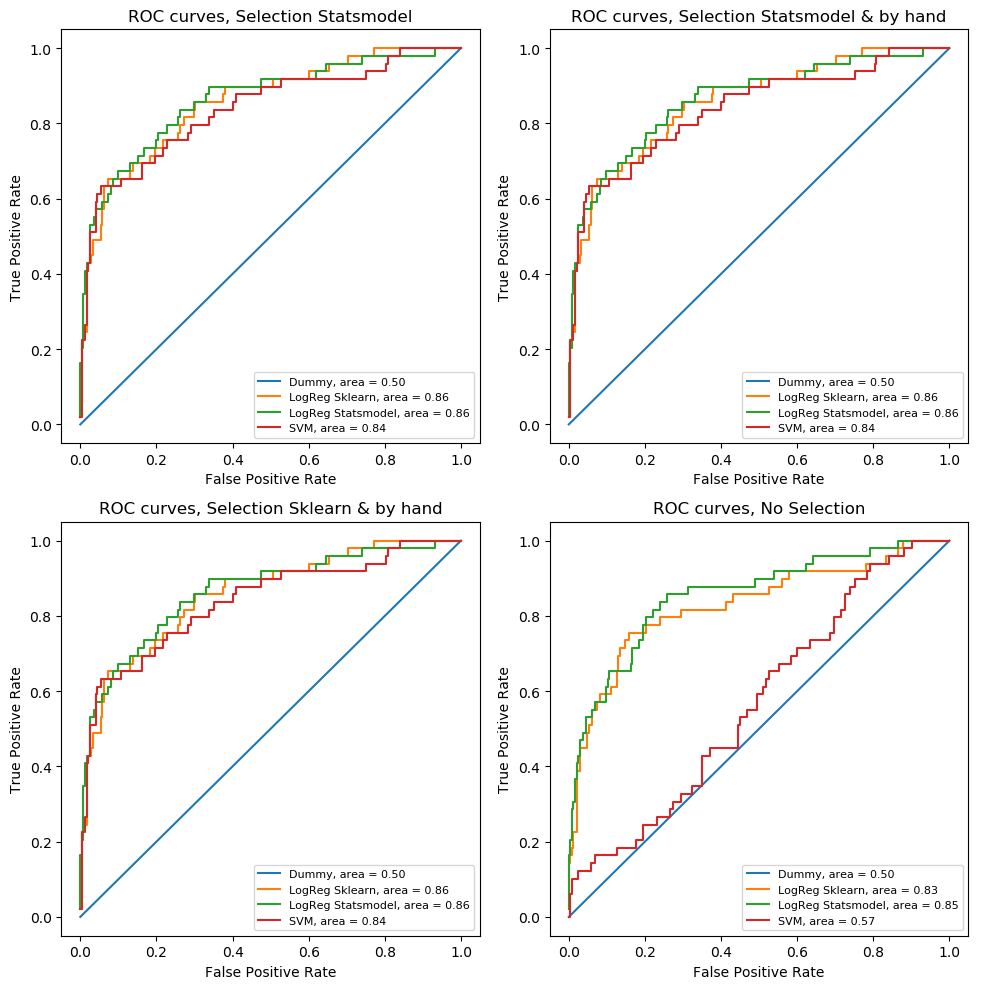

In [45]:
fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(2,2)

legend = ['Dummy','LogReg Sklearn', 'LogReg Statsmodel', 'SVM']

j = 0
for i in range(n):
    if i < 2 :
        plt.subplot(grid[0,i])
    else :
        plt.subplot(grid[1,j])
        j += 1 
    
    # Proportions pour le dummy_classifier, qui nous sert de base pour les autres modèles
    prop = sum(y_train_tot[i])/len(y_train_tot[i].index)
    dummy_prop = np.empty(len(y_test_tot[i].index))
    dummy_prop.fill(prop)
    
    # fit sur les training sets
    res_log = logreg.fit(X_train_tot[i], y_train_tot[i])
    res_sm = smlogit_result(y_train_tot[i], X_train_tot[i])
    res_svm = svm.fit(X_train_tot[i], y_train_tot[i])   
    
    models = [dummy_prop, res_log.decision_function(X_test_tot[i]), res_sm.predict(X_test_tot[i]), 
              res_svm.decision_function(X_test_tot[i])]
    
    k = 0
    for m in models:
        fpr,tpr,t = roc_curve(y_test,m)
        auc_ = auc(fpr,tpr)
        plt.plot(fpr, tpr, color = sns.color_palette()[k], label = legend[k] +', area = %0.02f' %auc_)
        k +=1

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves, ' + titre[i])
    plt.legend(loc = 'lower right', prop={'size':8} )

plt.tight_layout()
plt.show()

# Conclusion


- La sélection de variables grâce à Statmodels a été très performante en comparaison d'aucune sélection.
- Les regressions logistiques de Sklearn et statsmodels sont meilleures que le SVM pour la prédiction.
- Les deux regressions logistiques de sklearn et statsmodels ont des performances comparables.
- Nous n'avons pas réussi à construire un bon modèle à la main en supprimant les variables par backward regression et en retrouvant les p-values. Cela vient probablement des variables catégoriques qui ne sont pas bien intégrées dans la régression logistique.


# Annexes

Explication sur les bases de données :
- df = base totale avec la bonne taille
- dfc = df + variables cat transformées en dummy - variables inutiles (dont var cat) - variables corrélées
- X = dfc - Attrition + colonne de constantes  --> selection stats models
- X1 = dfc - Attrition + colonne de constantes  --> sélection pvalues recalculées à la main

Améliorations apportées au modèle:

- Suppression d'une catégorie par variable catégorique (pour avoir une matrice X de full rank)
- Changements dans la fonction p-value :
    - Initialisation de la fonction avec statsmodels pour trouver les paramètres et la prédiction
    - Suppression du carré pour le calcul de la statistique de Wald
- Ajout d'un même seed = 0 pour initialiser le générateur de nombres randoms de la même manière, notamment dans la fonction tain_test_split
   